<a href="https://colab.research.google.com/github/shabnomm/CustomCNN-Betel-Leaf-Image-Classification/blob/main/customcnn_cse366.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/betel-leaf-image-dataset-from-bangladesh/Betel Leaf Image Dataset from Bangladesh/Augmented Images/Test/Healthy Leaf/Healthy_Leaf-143-_jpg.rf.d13bb1b6345b3641aa00e01e00a63503.jpg
/kaggle/input/betel-leaf-image-dataset-from-bangladesh/Betel Leaf Image Dataset from Bangladesh/Augmented Images/Test/Healthy Leaf/Healthy_Leaf-46-_jpg.rf.a4989dc46a90bfa523e50ab50ca2f187.jpg
/kaggle/input/betel-leaf-image-dataset-from-bangladesh/Betel Leaf Image Dataset from Bangladesh/Augmented Images/Test/Healthy Leaf/Healthy_Leaf-187-_jpg.rf.bc26504c48249e6ff1f70502c1c132f3.jpg
/kaggle/input/betel-leaf-image-dataset-from-bangladesh/Betel Leaf Image Dataset from Bangladesh/Augmented Images/Test/Healthy Leaf/Healthy_Leaf-154-_jpg.rf.44f06fe93682e86495ff7d2960d8932a.jpg
/kaggle/input/betel-leaf-image-dataset-from-bangladesh/Betel Leaf Image Dataset from Bangladesh/Augmented Images/Test/Healthy Leaf/Healthy_Leaf-80-_jpg.rf.71f7e63c321c9cc0c6f102cbaed8401b.jpg
/kaggle/input/betel-leaf-image-datase

# **1.Import Libraries**
* Imports PyTorch, torchvision, and related libraries for building and training the model.
* Imports sklearn for evaluation metrics and matplotlib for plotting.
* GradScaler and autocast are used for mixed-precision training (faster training on GPU).

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import copy

# AMP compatibility (newer and older PyTorch versions)
try:
    from torch.amp import autocast, GradScaler
except ImportError:
    from torch.cuda.amp import autocast, GradScaler


# **2.Set Random Seed for Reproducibility**
* Ensures reproducibility by setting fixed seeds for Python, NumPy, and PyTorch.
* Guarantees that model behavior (e.g., weight initialization, data splitting) is consistent on every run.

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

# **3.Dataset Path and Transforms**
* Sets up image transformations: augmentation for training (resize, flip, rotate, jitter), normalization for all.
* Augmentations help the model generalize better by simulating real-world variations.

In [ ]:
data_dir = "/kaggle/input/betel-leaf-image-dataset-from-bangladesh/Betel Leaf Image Dataset from Bangladesh"

train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# **4.Load Dataset and Split**
* Uses torchvision.datasets.ImageFolder to load the dataset from folder structure.
* Splits the dataset into training (70%), validation (15%), and test (15%) using random_split.
* Applies appropriate transforms to each dataset (training uses augmentations, val/test don't).

In [ ]:
full_dataset = datasets.ImageFolder(root=data_dir)
class_names = full_dataset.classes  # Save class names before splitting

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
train_set.dataset.transform = train_transforms
val_set.dataset.transform = val_test_transforms
test_set.dataset.transform = val_test_transforms

train_dataset = train_set
val_dataset = val_set
test_dataset = test_set

print(f"Classes: {full_dataset.classes}")
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Classes: ['Augmented Images', 'Original Images']
Train size: 2512
Validation size: 538
Test size: 539


# **5.Create DataLoaders**
* Wraps datasets into DataLoaders to efficiently load data in batches (with shuffling for training).
* batch_size=32 balances speed and memory use; num_workers=2 allows parallel loading.

In [ ]:
batch_size = 32
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


# **6.Define CustomCNN Model**
* This section defines one custom Convolutional Neural Network (CNN) architectures tailored for classifying betel leaf images.
* Model includes layers like Conv2d, BatchNorm2d, ReLU, MaxPool2d, Dropout, and a final Linear layer to output predictions for the number of classes.
* Variations between CNN allow testing different depths, kernel sizes, dropout strategies, and complexity levels to find the best-performing model.

In [ ]:
# CustomCNN: Light model with dropout and batchnorm
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# **7.Initialize Device, Model, Loss, Optimizer, Scheduler, Scaler**
* Automatically selects GPU (cuda) if available, else defaults to CPU.
* Sets up CrossEntropyLoss for classification, Adam optimizer, and a learning rate scheduler.
* Scheduler reduces learning rate if validation loss plateaus.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
num_classes = len(class_names)
model = CustomCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler() if torch.cuda.is_available() else None

Using device: cuda


# **8.Train Function with Early Stopping and Mixed Precision**
* Defines the training loop for the model including validation after every epoch.
* Uses torch.cuda.amp for faster training if GPU is available (autocast + GradScaler).
* Implements early stopping based on F1-score to avoid overfitting and unnecessary epochs.

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, num_epochs=25, patience=7):
    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            if scaler is not None:
                # Mixed-precision training (faster on GPU)
                with autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # CPU mode or no AMP
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        # Average train loss
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_running_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
        print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val F1: {f1:.4f}")

        # LR scheduler
        scheduler.step(epoch_val_loss)

        # Early stopping logic
        if f1 > best_f1:
            best_f1 = f1
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            torch.save(model.state_dict(), "custom_cnn_best.pt")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses


# **9.Evaluation Function on Test Set**
* Evaluates the trained model on the test dataset and computes precision, recall, and F1-score.
* Generates a confusion matrix to visualize per-class performance.
* Useful for understanding how the model performs on unseen data.

In [ ]:
def evaluate_on_test(model, test_loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Test Set")
    plt.show()

# **10.Run Training**
* Calls the train_model() function with training, validation data and all setup.
* Saves the best model checkpoint based on validation F1-score.
* Returns loss values for plotting.

In [ ]:
num_epochs = 25
patience = 7

trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, num_epochs, patience
)

Epoch 1/25
Train Loss: 0.5452 | Val Loss: 0.5410 | Val F1: 0.5921
Epoch 2/25
Train Loss: 0.5217 | Val Loss: 0.5494 | Val F1: 0.6783
Epoch 3/25
Train Loss: 0.5169 | Val Loss: 0.5431 | Val F1: 0.6867
Epoch 4/25
Train Loss: 0.5173 | Val Loss: 0.5557 | Val F1: 0.6661
Epoch 5/25
Train Loss: 0.5020 | Val Loss: 0.5567 | Val F1: 0.6425
Epoch 6/25
Train Loss: 0.4891 | Val Loss: 0.5069 | Val F1: 0.7016
Epoch 7/25
Train Loss: 0.4821 | Val Loss: 0.5564 | Val F1: 0.6606
Epoch 8/25
Train Loss: 0.4741 | Val Loss: 0.6348 | Val F1: 0.5839
Epoch 9/25
Train Loss: 0.4679 | Val Loss: 0.6533 | Val F1: 0.5659
Epoch 10/25
Train Loss: 0.4564 | Val Loss: 0.4821 | Val F1: 0.7619
Epoch 11/25
Train Loss: 0.4440 | Val Loss: 0.7981 | Val F1: 0.5028
Epoch 12/25
Train Loss: 0.4336 | Val Loss: 0.4646 | Val F1: 0.7514
Epoch 13/25
Train Loss: 0.4201 | Val Loss: 0.9074 | Val F1: 0.4734
Epoch 14/25
Train Loss: 0.4078 | Val Loss: 0.4833 | Val F1: 0.7572
Epoch 15/25
Train Loss: 0.3992 | Val Loss: 0.7437 | Val F1: 0.5815
Epoc

# **11.Plot Loss Curves**
* Plots training and validation loss per epoch to visually inspect learning progress.
* Helps diagnose underfitting or overfitting.

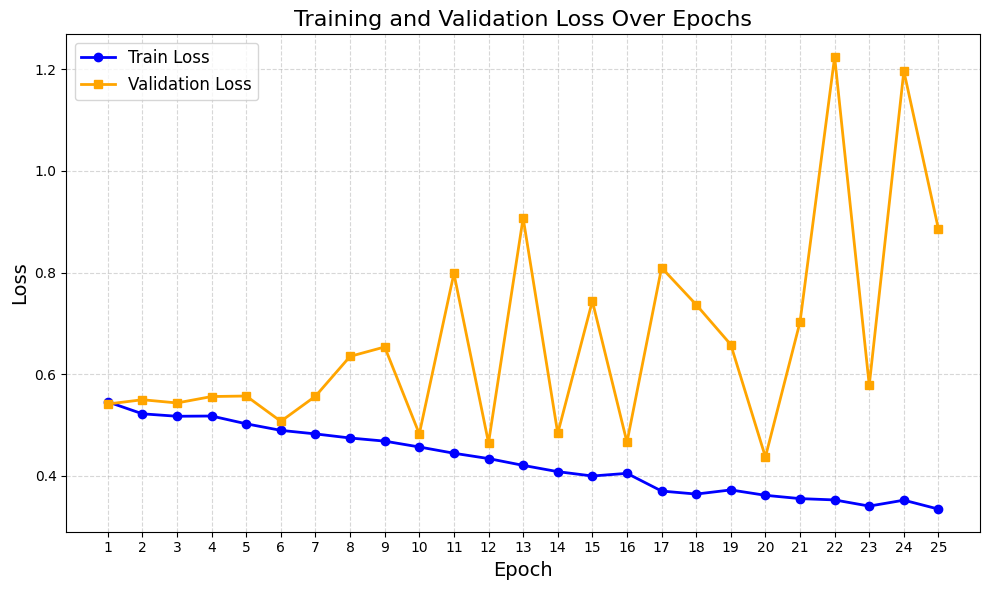

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", color='blue', linewidth=2, marker='o')
plt.plot(val_losses, label="Validation Loss", color='orange', linewidth=2, marker='s')

plt.title("Training and Validation Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(ticks=np.arange(len(train_losses)), labels=np.arange(1, len(train_losses)+1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# **12.Final Evaluation**
* Loads the best model and runs evaluate_on_test() to print final performance.
* Visualization (confusion matrix) gives clear insight into class-wise accuracy.

Test Precision: 0.8683
Test Recall: 0.8126
Test F1-score: 0.8240


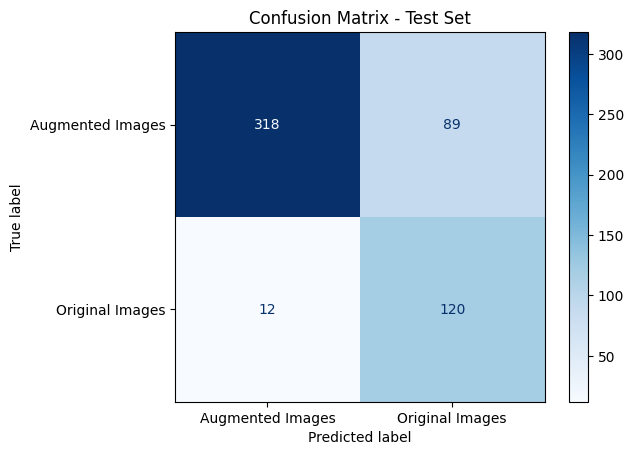

In [ ]:
evaluate_on_test(trained_model, test_loader, device, class_names)
